In [1]:
import diffrax
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = [14, 10]
plt.rcParams["font.size"] = 11
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 13

## System definition

In [2]:
129e-15 / 0.5

2.58e-13

In [3]:
# Neuromorphic system parameters (dimensionless)
alpha = 0.5  # I_n0 / I_bias ratio
beta = 1.5  # k / U_t (inverse thermal scale)
gamma = 0.26  # coupling coefficient
kappa = 5.0  # tanh steepness
sigma = 0.6  # bias scaling (s * I_bias normalized)

# Classic Lotka-Volterra parameters
a = 1.0  # prey growth rate
b = 0.5  # predation rate
c = 0.5  # predator death rate
d = 0.5  # predator growth from prey


def z_func(u, v):
    """Coupling function"""
    return jnp.tanh(kappa * (u - v))


def neuromorphic_system(t, state, args):
    """
    Neuromorphic oscillator interpreted as predator-prey
    u = prey, v = predator
    """
    u, v = state
    z = z_func(u, v)

    # Prey dynamics
    du = z * (1 - alpha * jnp.exp(beta * v) * (1 + gamma * (0.5 - u))) - sigma

    # Predator dynamics
    dv = z * (-1 + alpha * jnp.exp(beta * u) * (1 + gamma * (0.5 - v))) - sigma

    return jnp.array([du, dv])


def lotka_volterra(t, state, args):
    """Classic predator-prey system"""
    x, y = state
    dx = x * (a - b * y)
    dy = y * (-c + d * x)
    return jnp.array([dx, dy])


def generalized_predator_prey(state, t):
    """
    Modified Lotka-Volterra with saturation (for fairer comparison)
    """
    x, y = state
    K = 3.0  # carrying capacity
    dx = x * (a * (1 - x / K) - b * y)
    dy = y * (-c + d * x)
    return jnp.array([dx, dy])


def solve(dyn, y0, p, T, n=1000):
    sol = diffrax.diffeqsolve(
        diffrax.ODETerm(dyn),
        diffrax.Tsit5(),
        t0=0.0,
        t1=T,
        dt0=0.01,
        y0=y0,
        args=p,
        saveat=diffrax.SaveAt(ts=jnp.linspace(0, T, n)),
        stepsize_controller=diffrax.PIDController(rtol=1e-6, atol=1e-8),
        max_steps=50000,
    )
    return sol.ts, sol.ys

In [4]:
def compute_nullclines_neuromorphic(u_range, v_range, resolution=200):
    """
    Compute nullclines for neuromorphic system
    du/dt = 0 (u-nullcline)
    dv/dt = 0 (v-nullcline)
    """
    u_vals = jnp.linspace(u_range[0], u_range[1], resolution)
    v_vals = jnp.linspace(v_range[0], v_range[1], resolution)
    U, V = jnp.meshgrid(u_vals, v_vals)

    Z = z_func(U, V)

    # du/dt
    dU = Z * (1 - alpha * jnp.exp(beta * V) * (1 + gamma * (0.5 - U))) - sigma

    # dv/dt
    dV = Z * (-1 + alpha * jnp.exp(beta * U) * (1 + gamma * (0.5 - V))) - sigma

    return U, V, dU, dV


def compute_nullclines_lotka_volterra(x_range, y_range, resolution=200):
    """Compute nullclines for classic Lotka-Volterra"""
    x_vals = jnp.linspace(x_range[0], x_range[1], resolution)
    y_vals = jnp.linspace(y_range[0], y_range[1], resolution)
    X, Y = jnp.meshgrid(x_vals, y_vals)

    # dx/dt = x(a - by)
    dX = X * (a - b * Y)

    # dy/dt = y(-c + dx)
    dY = Y * (-c + d * X)

    return X, Y, dX, dY

## Fixpoint analysis

In [ ]:
def newton_fp(f, x0, p, tol=1e-12, iters=50):
    x = jnp.array(x0)
    for _ in range(iters):
        fx = f(0.0, x, p)
        J = jax.jacrev(lambda y: f(0.0, y, p))(x)
        x = x - jnp.linalg.solve(J, fx)
        if jnp.linalg.norm(fx) < tol:
            return x, True
    return x, False


def find_fixed_points(fn):
    """Find fixed points numerically"""
    fixed_points = []

    # Try multiple initial guesses
    initial_guesses = [
        [0.0, 0.0],
        [0.5, 0.5],
        [-0.5, -0.5],
        [1.0, 0.0],
        [0.0, 1.0],
        [-1.0, 0.0],
        [0.5, -0.5],
        [-0.5, 0.5],
        [0.3, 0.3],
        [2.0, 0.0],
        [0.0, 2.0],
        [-2.0, 0.0],
        [1.5, -1.5],
        [-1.5, 1.5],
        [1.3, 1.3],
        [2.0, -1.5],
        [-2.5, 1.5],
        [2, 1.5],
    ]

    for guess in initial_guesses:
        point, _ = newton_fp(fn, guess, None)

        # Check if it's actually a fixed point
        residual = jnp.linalg.norm(fn(0, point, None))
        if residual < 1e-6:
            # Check if we already have this point
            is_new = True
            for fp in fixed_points:
                if jnp.linalg.norm(jnp.array(fp) - jnp.array(point)) < 0.01:
                    is_new = False
                    break
            if is_new:
                fixed_points.append(point.tolist())

    return fixed_points


# find_fixed_points(neuromorphic_system)
find_fixed_points(lotka_volterra)

[[0.0, 0.0], [1.0, 2.0]]

## Stability

In [6]:
def calc_jacobian(u, v, fn, eps=1e-6):
    """Numerical Jacobian for neuromorphic system"""
    jac = jax.jacobian(fn, argnums=1)(0, [u, v], None)

    J = jnp.zeros((2, 2))
    # Partial derivatives
    J = J.at[0, 0].set(jac[0][0])
    J = J.at[0, 1].set(jac[0][1])
    J = J.at[1, 0].set(jac[1][0])
    J = J.at[1, 1].set(jac[1][1])

    return J


def analyze_stability(J):
    """Analyze stability from Jacobian eigenvalues"""
    eigenvalues = jnp.linalg.eigvals(J)

    real_parts = jnp.real(eigenvalues)
    imag_parts = jnp.imag(eigenvalues)

    # Classification
    if all(r < 0 for r in real_parts):
        if any(abs(i) > 1e-10 for i in imag_parts):
            stability = "Stable Focus (spiral sink)"
        else:
            stability = "Stable Node"
    elif all(r > 0 for r in real_parts):
        if any(abs(i) > 1e-10 for i in imag_parts):
            stability = "Unstable Focus (spiral source)"
        else:
            stability = "Unstable Node"
    elif real_parts[0] * real_parts[1] < 0:
        stability = "Saddle Point"
    else:
        if any(abs(i) > 1e-10 for i in imag_parts):
            stability = "Center (neutral)"
        else:
            stability = "Non-hyperbolic"

    return eigenvalues, stability

# Main

In [7]:
print("=" * 70)
print("PREDATOR-PREY ANALYSIS: NEUROMORPHIC vs LOTKA-VOLTERRA")
print("=" * 70)

# --- Fixed Points ---
print("\n" + "=" * 70)
print("1. FIXED POINT ANALYSIS")
print("=" * 70)

print("\n--- Neuromorphic System ---")
fp_neuro = find_fixed_points(neuromorphic_system)
print(f"Found {len(fp_neuro)} fixed point(s):")
for i, fp in enumerate(fp_neuro):
    print(f"  FP{i + 1}: (u*, v*) = ({fp[0]:.4f}, {fp[1]:.4f})")
    J = calc_jacobian(fp[0], fp[1], neuromorphic_system)
    eigs, stability = analyze_stability(J)
    print(f"        Eigenvalues: λ₁ = {eigs[0]:.4f}, λ₂ = {eigs[1]:.4f}")
    print(f"        Classification: {stability}")

print("\n--- Lotka-Volterra System ---")
fp_lv = find_fixed_points(lotka_volterra)
print("Fixed points:")
for i, fp in enumerate(fp_lv):
    print(f"  FP{i + 1}: (x*, y*) = ({fp[0]:.4f}, {fp[1]:.4f})")
    if fp[0] > 0 or fp[1] > 0:  # avoid division issues at origin
        J = calc_jacobian(fp[0], fp[1], lotka_volterra)
        eigs, stability = analyze_stability(J)
        print(f"        Eigenvalues: λ₁ = {eigs[0]:.4f}, λ₂ = {eigs[1]:.4f}")
        print(f"        Classification: {stability}")
    else:
        print("        (Origin - typically a saddle)")

print("\n" + "=" * 70)
print("2. NULLCLINE EQUATIONS")
print("=" * 70)

print("\n--- Neuromorphic System ---")
print("u-nullcline (du/dt = 0):")
print("  z·[1 - α·exp(βv)·(1 + γ(½-u))] = σ")
print("  where z = tanh(κ(u-v))")
print("\nv-nullcline (dv/dt = 0):")
print("  z·[-1 + α·exp(βu)·(1 + γ(½-v))] = σ")

print("\n--- Lotka-Volterra System ---")
print("x-nullcline (dx/dt = 0):")
print("  x = 0  OR  y = a/b")
print("\ny-nullcline (dy/dt = 0):")
print("  y = 0  OR  x = c/d")

PREDATOR-PREY ANALYSIS: NEUROMORPHIC vs LOTKA-VOLTERRA

1. FIXED POINT ANALYSIS

--- Neuromorphic System ---
Found 2 fixed point(s):
  FP1: (u*, v*) = (0.6762, -0.1182)
        Eigenvalues: λ₁ = -0.1247+1.1803j, λ₂ = -0.1247-1.1803j
        Classification: Stable Focus (spiral sink)
  FP2: (u*, v*) = (-0.1182, 0.6762)
        Eigenvalues: λ₁ = -0.1247+1.1803j, λ₂ = -0.1247-1.1803j
        Classification: Stable Focus (spiral sink)

--- Lotka-Volterra System ---
Fixed points:
  FP1: (x*, y*) = (0.0000, 0.0000)
        (Origin - typically a saddle)
  FP2: (x*, y*) = (1.0000, 2.0000)
        Eigenvalues: λ₁ = 0.0000+0.7071j, λ₂ = 0.0000-0.7071j
        Classification: Center (neutral)

2. NULLCLINE EQUATIONS

--- Neuromorphic System ---
u-nullcline (du/dt = 0):
  z·[1 - α·exp(βv)·(1 + γ(½-u))] = σ
  where z = tanh(κ(u-v))

v-nullcline (dv/dt = 0):
  z·[-1 + α·exp(βu)·(1 + γ(½-v))] = σ

--- Lotka-Volterra System ---
x-nullcline (dx/dt = 0):
  x = 0  OR  y = a/b

y-nullcline (dy/dt = 0):
  

## Visualization

/tmp/ipykernel_2751701/1982221629.py:146: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  plt.tight_layout()
/home/p306945/Projects/felice/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


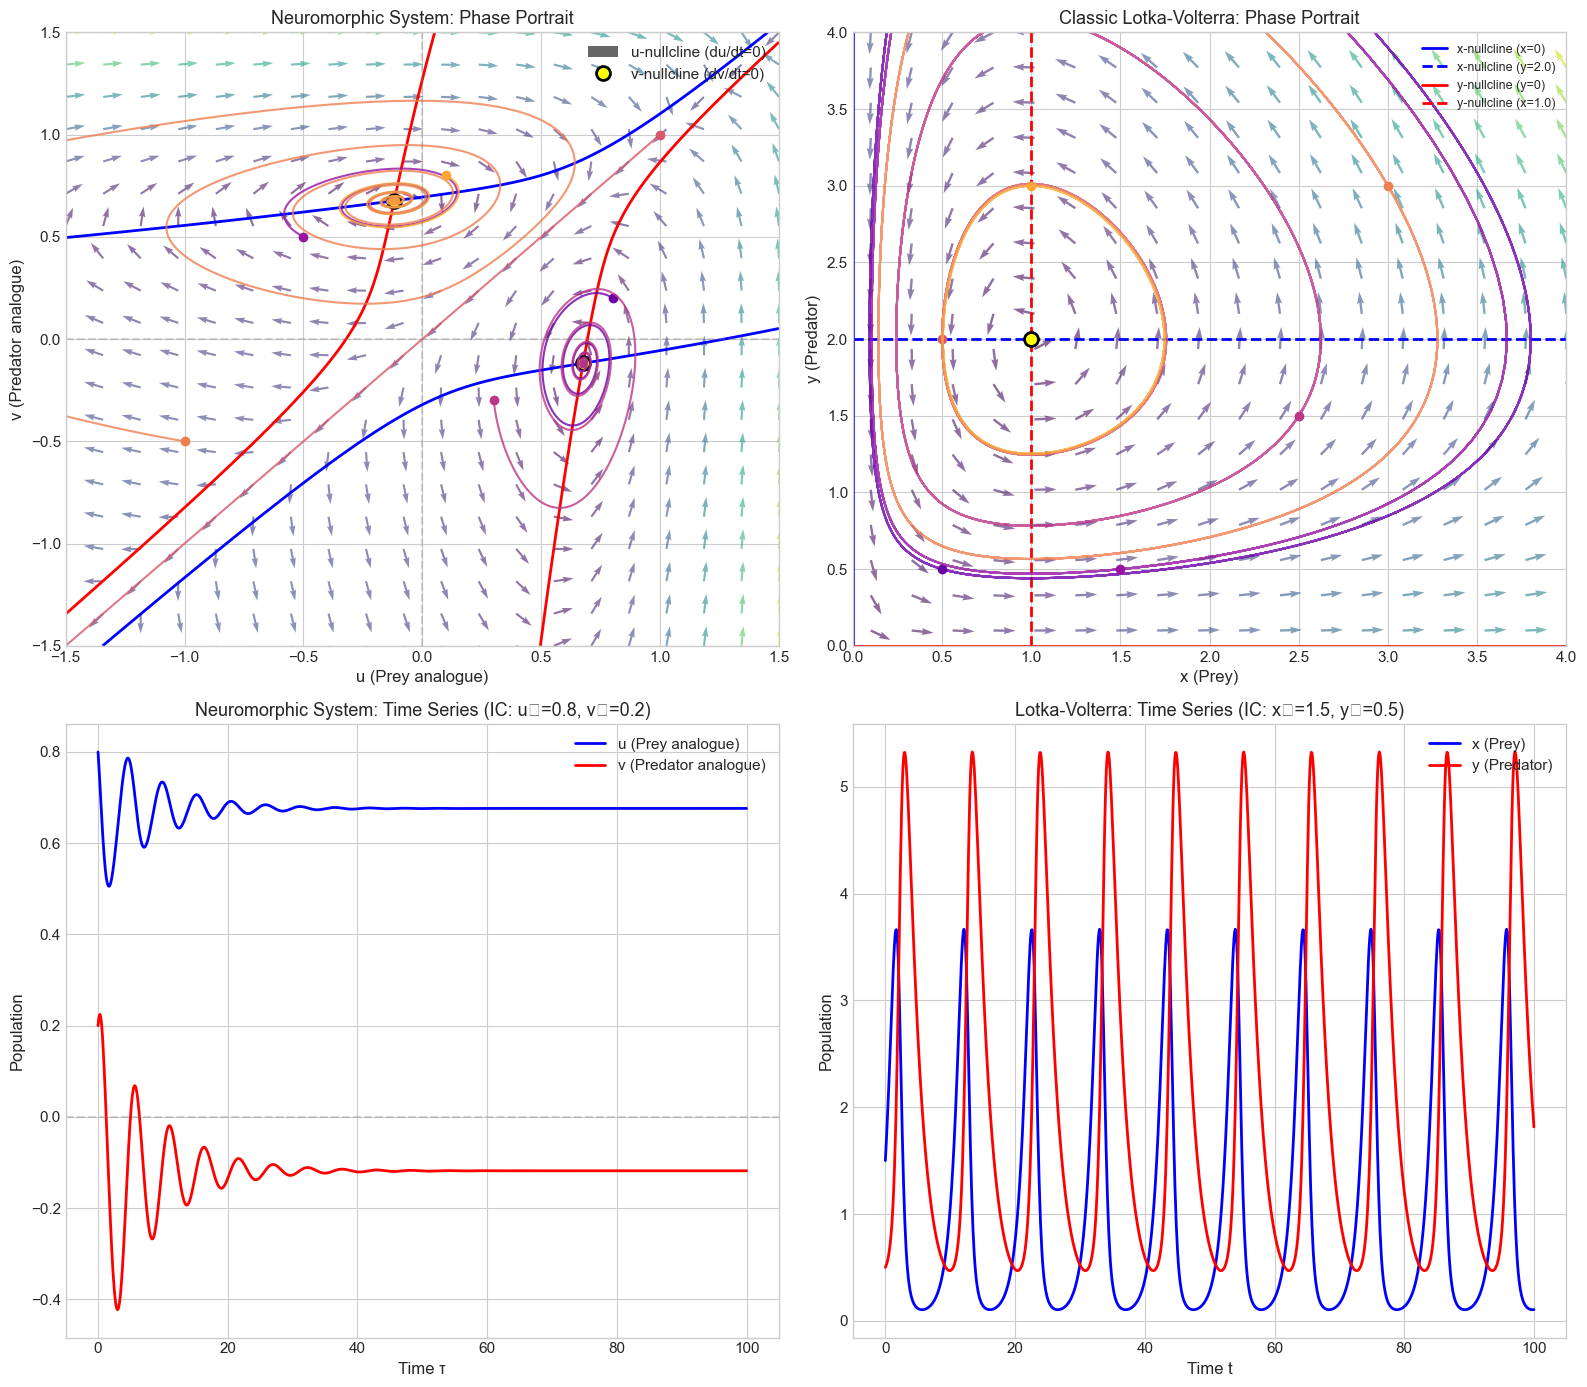


3. PHASE PORTRAIT SAVED
Saved: phase_portrait_comparison.png


In [ ]:
fig = plt.figure(figsize=(16, 14))

# --- Plot 1: Neuromorphic Phase Portrait ---
ax1 = fig.add_subplot(2, 2, 1)

u_range = [-1.5, 1.5]
v_range = [-1.5, 1.5]
U, V, dU, dV = compute_nullclines_neuromorphic(u_range, v_range)

# Nullclines
ax1.contour(U, V, dU, levels=[0], colors="blue", linewidths=2, linestyles="-")
ax1.contour(U, V, dV, levels=[0], colors="red", linewidths=2, linestyles="-")

# Vector field
u_sparse = np.linspace(u_range[0], u_range[1], 20)
v_sparse = np.linspace(v_range[0], v_range[1], 20)
Us, Vs = np.meshgrid(u_sparse, v_sparse)
dUs = np.zeros_like(Us)
dVs = np.zeros_like(Vs)
for i in range(Us.shape[0]):
    for j in range(Us.shape[1]):
        deriv = neuromorphic_system(0, [Us[i, j], Vs[i, j]], None)
        dUs[i, j] = deriv[0]
        dVs[i, j] = deriv[1]

# Normalize for visualization
magnitude = np.sqrt(dUs**2 + dVs**2)
magnitude[magnitude == 0] = 1
dUs_norm = dUs / magnitude
dVs_norm = dVs / magnitude

ax1.quiver(Us, Vs, dUs_norm, dVs_norm, magnitude, cmap="viridis", alpha=0.6)

# Fixed points
for fp in fp_neuro:
    ax1.plot(
        fp[0], fp[1], "ko", markersize=10, markerfacecolor="yellow", markeredgewidth=2
    )

# Trajectories
t = 50  # np.linspace(0, 50, 2000)
initial_conditions = [
    [0.8, 0.2],
    [-0.5, 0.5],
    [0.3, -0.3],
    [1.0, 1.0],
    [-1.0, -0.5],
    [0.1, 0.8],
]
colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(initial_conditions)))

for ic, color in zip(initial_conditions, colors):
    # sol = odeint(neuromorphic_system, ic, t)
    ts, ys = solve(neuromorphic_system, jnp.array(ic), None, t)
    ax1.plot(ys[:, 0], ys[:, 1], "-", color=color, linewidth=1.5, alpha=0.8)
    ax1.plot(ic[0], ic[1], "o", color=color, markersize=6)

ax1.set_xlabel("u (Prey analogue)")
ax1.set_ylabel("v (Predator analogue)")
ax1.set_title("Neuromorphic System: Phase Portrait")
ax1.legend(["u-nullcline (du/dt=0)", "v-nullcline (dv/dt=0)"], loc="upper right")
ax1.set_xlim(u_range)
ax1.set_ylim(v_range)
ax1.axhline(y=0, color="gray", linestyle="--", alpha=0.3)
ax1.axvline(x=0, color="gray", linestyle="--", alpha=0.3)

# --- Plot 2: Lotka-Volterra Phase Portrait ---
ax2 = fig.add_subplot(2, 2, 2)

x_range = [0, 4]
y_range = [0, 4]
X, Y, dX, dY = compute_nullclines_lotka_volterra(x_range, y_range)

# Nullclines (analytical)
ax2.axvline(x=0, color="blue", linewidth=2, label="x-nullcline (x=0)")
ax2.axhline(
    y=a / b,
    color="blue",
    linewidth=2,
    linestyle="--",
    label=f"x-nullcline (y={a / b:.1f})",
)
ax2.axhline(y=0, color="red", linewidth=2, label="y-nullcline (y=0)")
ax2.axvline(
    x=c / d,
    color="red",
    linewidth=2,
    linestyle="--",
    label=f"y-nullcline (x={c / d:.1f})",
)

# Vector field
x_sparse = np.linspace(0.1, x_range[1], 18)
y_sparse = np.linspace(0.1, y_range[1], 18)
Xs, Ys = np.meshgrid(x_sparse, y_sparse)
dXs = np.zeros_like(Xs)
dYs = np.zeros_like(Ys)
for i in range(Xs.shape[0]):
    for j in range(Xs.shape[1]):
        deriv = lotka_volterra(0, [Xs[i, j], Ys[i, j]], None)
        dXs[i, j] = deriv[0]
        dYs[i, j] = deriv[1]

magnitude = np.sqrt(dXs**2 + dYs**2)
magnitude[magnitude == 0] = 1
dXs_norm = dXs / magnitude
dYs_norm = dYs / magnitude

ax2.quiver(Xs, Ys, dXs_norm, dYs_norm, magnitude, cmap="viridis", alpha=0.6)

# Fixed point
ax2.plot(c / d, a / b, "ko", markersize=10, markerfacecolor="yellow", markeredgewidth=2)

# Trajectories
initial_conditions_lv = [
    [0.5, 0.5],
    [1.5, 0.5],
    [2.5, 1.5],
    [0.5, 2.0],
    [3.0, 3.0],
    [1.0, 3.0],
]

for ic, color in zip(initial_conditions_lv, colors):
    ts, ys = solve(lotka_volterra, jnp.array(ic), None, t)
    ax2.plot(ys[:, 0], ys[:, 1], "-", color=color, linewidth=1.5, alpha=0.8)
    ax2.plot(ic[0], ic[1], "o", color=color, markersize=6)

ax2.set_xlabel("x (Prey)")
ax2.set_ylabel("y (Predator)")
ax2.set_title("Classic Lotka-Volterra: Phase Portrait")
ax2.set_xlim([0, x_range[1]])
ax2.set_ylim([0, y_range[1]])
ax2.legend(loc="upper right", fontsize=9)

ax3 = fig.add_subplot(2, 2, 3)

t_long = 100
ic_neuro = [0.8, 0.2]
ts, ys = solve(neuromorphic_system, jnp.array(ic_neuro), None, t_long)

ax3.plot(ts, ys[:, 0], "b-", linewidth=2, label="u (Prey analogue)")
ax3.plot(ts, ys[:, 1], "r-", linewidth=2, label="v (Predator analogue)")
ax3.set_xlabel("Time τ")
ax3.set_ylabel("Population")
ax3.set_title(
    f"Neuromorphic System: Time Series (IC: u₀={ic_neuro[0]}, v₀={ic_neuro[1]})"
)
ax3.legend()
ax3.axhline(y=0, color="gray", linestyle="--", alpha=0.3)

ax4 = fig.add_subplot(2, 2, 4)

ic_lv = [1.5, 0.5]
ts, ys = solve(lotka_volterra, jnp.array(ic_lv), None, t_long)

ax4.plot(ts, ys[:, 0], "b-", linewidth=2, label="x (Prey)")
ax4.plot(ts, ys[:, 1], "r-", linewidth=2, label="y (Predator)")
ax4.set_xlabel("Time t")
ax4.set_ylabel("Population")
ax4.set_title(f"Lotka-Volterra: Time Series (IC: x₀={ic_lv[0]}, y₀={ic_lv[1]})")
ax4.legend()

plt.tight_layout()
# plt.savefig('/home/claude/phase_portrait_comparison.png', dpi=150, bbox_inches='tight')
# plt.close()
plt.show()

print("\n" + "=" * 70)
print("3. PHASE PORTRAIT SAVED")
print("=" * 70)
print("Saved: phase_portrait_comparison.png")

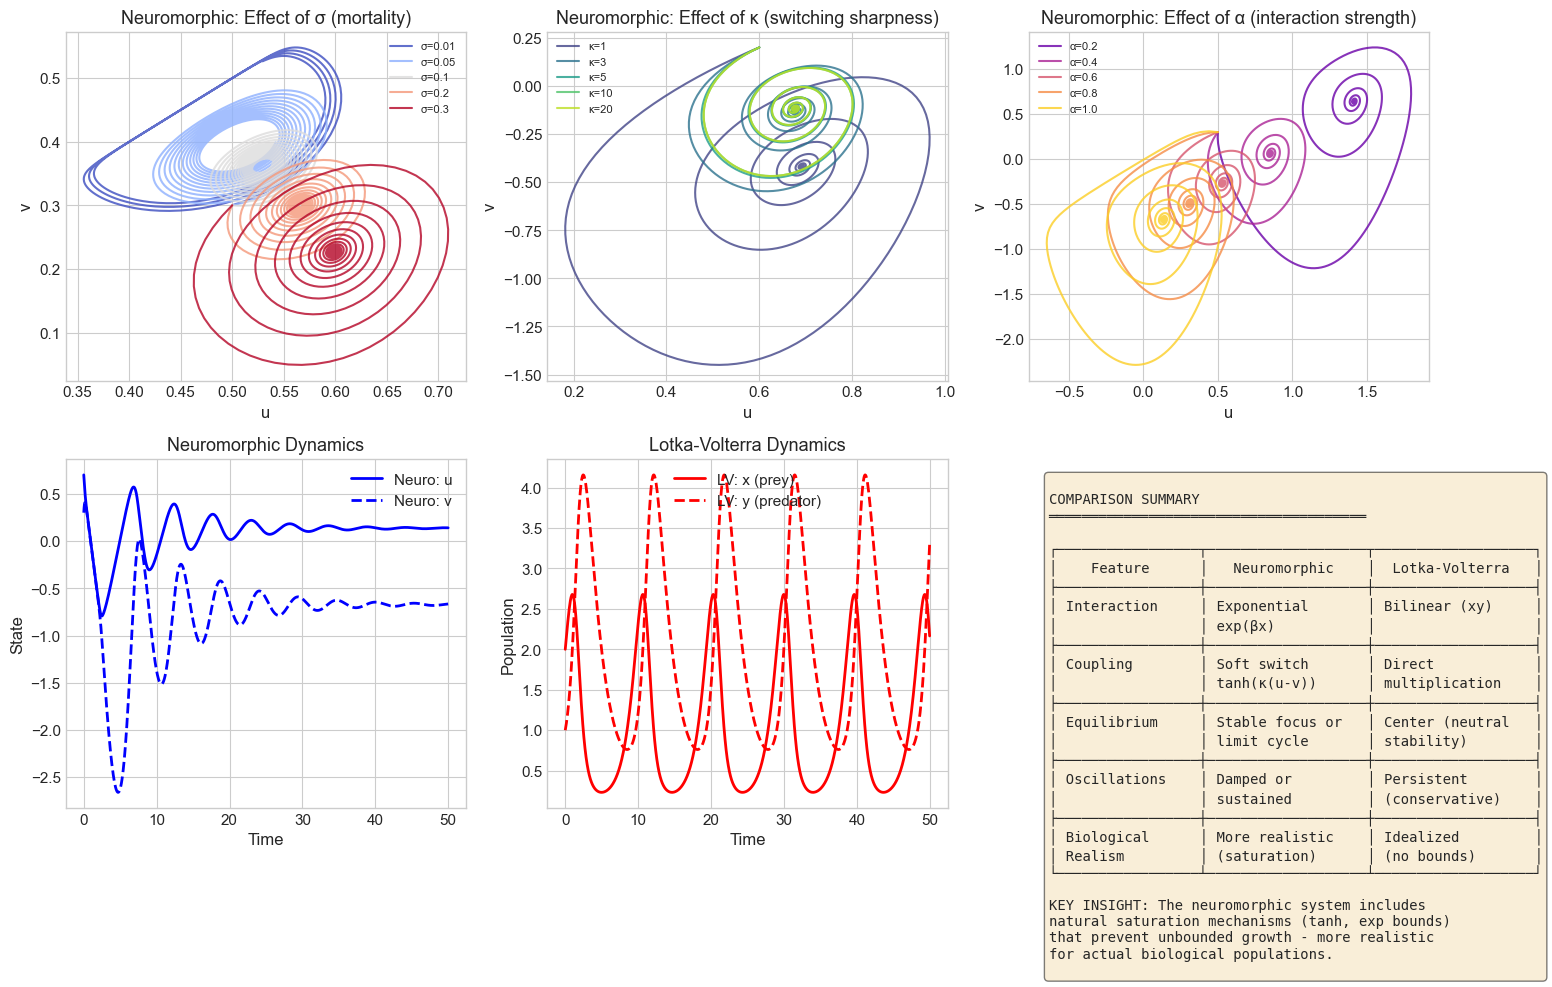

In [ ]:
fig2, axes = plt.subplots(2, 3, figsize=(16, 10))

# --- Bifurcation-like analysis: vary sigma ---
ax = axes[0, 0]
sigmas = [0.01, 0.05, 0.1, 0.2, 0.3]
colors_sigma = plt.cm.coolwarm(np.linspace(0, 1, len(sigmas)))

for sig, col in zip(sigmas, colors_sigma):

    def neuro_temp(t, state, args):
        u, v = state
        z = jnp.tanh(kappa * (u - v))
        du = z * (1 - alpha * jnp.exp(beta * v) * (1 + gamma * (0.5 - u))) - sig
        dv = z * (-1 + alpha * jnp.exp(beta * u) * (1 + gamma * (0.5 - v))) - sig
        return jnp.asarray([du, dv])

    ts, ys = solve(neuro_temp, jnp.array([0.5, 0.3]), None, 80)
    ax.plot(
        ys[:, 0], ys[:, 1], "-", color=col, linewidth=1.5, label=f"σ={sig}", alpha=0.8
    )

ax.set_xlabel("u")
ax.set_ylabel("v")
ax.set_title("Neuromorphic: Effect of σ (mortality)")
ax.legend(fontsize=8)

ax = axes[0, 1]
kappas = [1, 3, 5, 10, 20]
colors_kappa = plt.cm.viridis(np.linspace(0.2, 0.9, len(kappas)))

for kap, col in zip(kappas, colors_kappa):

    def neuro_temp(t, state, args):
        u, v = state
        z = jnp.tanh(kap * (u - v))
        du = z * (1 - alpha * jnp.exp(beta * v) * (1 + gamma * (0.5 - u))) - sigma
        dv = z * (-1 + alpha * jnp.exp(beta * u) * (1 + gamma * (0.5 - v))) - sigma
        return jnp.asarray([du, dv])

    ts, ys = solve(neuro_temp, jnp.array([0.6, 0.2]), None, 60)
    ax.plot(
        ys[:, 0], ys[:, 1], "-", color=col, linewidth=1.5, label=f"κ={kap}", alpha=0.8
    )

ax.set_xlabel("u")
ax.set_ylabel("v")
ax.set_title("Neuromorphic: Effect of κ (switching sharpness)")
ax.legend(fontsize=8)

# --- Vary alpha (interaction strength) ---
ax = axes[0, 2]
alphas = [0.2, 0.4, 0.6, 0.8, 1.0]
colors_alpha = plt.cm.plasma(np.linspace(0.2, 0.9, len(alphas)))

for alp, col in zip(alphas, colors_alpha):

    def neuro_temp(t, state, args):
        u, v = state
        z = jnp.tanh(kappa * (u - v))
        du = z * (1 - alp * jnp.exp(beta * v) * (1 + gamma * (0.5 - u))) - sigma
        dv = z * (-1 + alp * jnp.exp(beta * u) * (1 + gamma * (0.5 - v))) - sigma
        return jnp.array([du, dv])

    ts, sol = solve(neuro_temp, jnp.array([0.5, 0.3]), None, 60)
    ax.plot(
        sol[:, 0], sol[:, 1], "-", color=col, linewidth=1.5, label=f"α={alp}", alpha=0.8
    )

ax.set_xlabel("u")
ax.set_ylabel("v")
ax.set_title("Neuromorphic: Effect of α (interaction strength)")
ax.legend(fontsize=8)

# --- Compare dynamics qualitatively ---
ax = axes[1, 0]

# Neuromorphic
t_comp, sol1 = solve(neuro_temp, jnp.array([0.7, 0.3]), None, 50)
ax.plot(t_comp, sol1[:, 0], "b-", linewidth=2, label="Neuro: u")
ax.plot(t_comp, sol1[:, 1], "b--", linewidth=2, label="Neuro: v")

ax.set_xlabel("Time")
ax.set_ylabel("State")
ax.set_title("Neuromorphic Dynamics")
ax.legend()

# --- Lotka-Volterra comparison ---
ax = axes[1, 1]
t_comp, sol2 = solve(lotka_volterra, jnp.array([2.0, 1.0]), None, 50)
ax.plot(t_comp, sol2[:, 0], "r-", linewidth=2, label="LV: x (prey)")
ax.plot(t_comp, sol2[:, 1], "r--", linewidth=2, label="LV: y (predator)")

ax.set_xlabel("Time")
ax.set_ylabel("Population")
ax.set_title("Lotka-Volterra Dynamics")
ax.legend()

# --- Summary comparison ---
ax = axes[1, 2]
ax.axis("off")

summary_text = """
COMPARISON SUMMARY
══════════════════════════════════════

┌─────────────────┬───────────────────┬───────────────────┐
│    Feature      │   Neuromorphic    │  Lotka-Volterra   │
├─────────────────┼───────────────────┼───────────────────┤
│ Interaction     │ Exponential       │ Bilinear (xy)     │
│                 │ exp(βx)           │                   │
├─────────────────┼───────────────────┼───────────────────┤
│ Coupling        │ Soft switch       │ Direct            │
│                 │ tanh(κ(u-v))      │ multiplication    │
├─────────────────┼───────────────────┼───────────────────┤
│ Equilibrium     │ Stable focus or   │ Center (neutral   │
│                 │ limit cycle       │ stability)        │
├─────────────────┼───────────────────┼───────────────────┤
│ Oscillations    │ Damped or         │ Persistent        │
│                 │ sustained         │ (conservative)    │
├─────────────────┼───────────────────┼───────────────────┤
│ Biological      │ More realistic    │ Idealized         │
│ Realism         │ (saturation)      │ (no bounds)       │
└─────────────────┴───────────────────┴───────────────────┘

KEY INSIGHT: The neuromorphic system includes
natural saturation mechanisms (tanh, exp bounds)
that prevent unbounded growth - more realistic
for actual biological populations.
"""

ax.text(
    0.05,
    0.95,
    summary_text,
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    fontfamily="monospace",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

plt.tight_layout()
# plt.savefig('/home/claude/detailed_comparison.png', dpi=150, bbox_inches='tight')
# plt.close()
plt.show()